In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score
)

In [3]:
# 1. Generate a synthetic binary classification dataset
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                           n_redundant=5, n_classes=2, random_state=42)

In [4]:
# 2. Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [5]:
# 3. Simulate a semi-supervised scenario by hiding labels for 70% of the training data.
rng = np.random.RandomState(42)
y_train_semi = np.copy(y_train)
mask = rng.rand(len(y_train_semi)) < 0.7  # 70% unlabeled
y_train_semi[mask] = -1  # In scikit-learn, unlabeled data are marked with -1

# Also create a fully supervised training subset (only using labeled data)
X_train_sup = X_train[y_train_semi != -1]
y_train_sup = y_train[y_train_semi != -1]


In [6]:
# 4. Define the base estimator: Random Forest
base_rf = RandomForestClassifier(n_estimators=100, random_state=42)

In [7]:
# 5. Fully supervised Random Forest model
rf_supervised = RandomForestClassifier(n_estimators=100, random_state=42)
rf_supervised.fit(X_train_sup, y_train_sup)

RandomForestClassifier(random_state=42)

In [8]:
# 6. Semi-supervised model using SelfTrainingClassifier with Random Forest as the base
self_training_rf = SelfTrainingClassifier(base_rf)
self_training_rf.fit(X_train, y_train_semi)

SelfTrainingClassifier(estimator=RandomForestClassifier(random_state=42))

In [9]:
# 7. Evaluate both models on the test set
y_pred_supervised = rf_supervised.predict(X_test)
y_pred_semi = self_training_rf.predict(X_test)
print("Classification Report - Fully Supervised Model:\n")
print(classification_report(y_test, y_pred_supervised))
print("\nClassification Report - Semi-Supervised Model:\n")
print(classification_report(y_test, y_pred_semi))

Classification Report - Fully Supervised Model:

              precision    recall  f1-score   support

           0       0.87      0.90      0.88       207
           1       0.89      0.85      0.87       193

    accuracy                           0.88       400
   macro avg       0.88      0.87      0.87       400
weighted avg       0.88      0.88      0.87       400


Classification Report - Semi-Supervised Model:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       207
           1       0.82      0.81      0.82       193

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



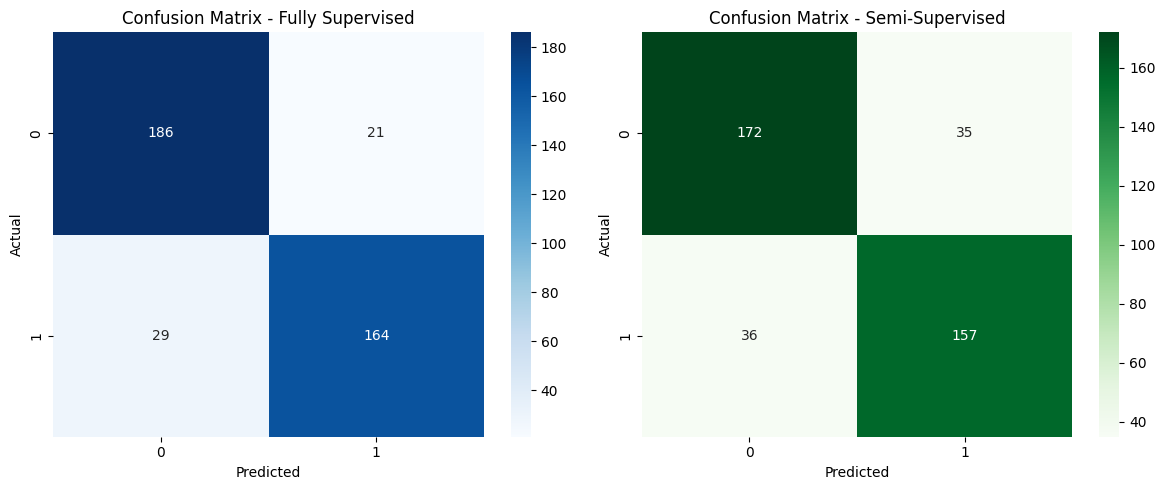

In [10]:
# 8. Plot confusion matrices
cm_supervised = confusion_matrix(y_test, y_pred_supervised)
cm_semi = confusion_matrix(y_test, y_pred_semi)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_supervised, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - Fully Supervised")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_semi, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title("Confusion Matrix - Semi-Supervised")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

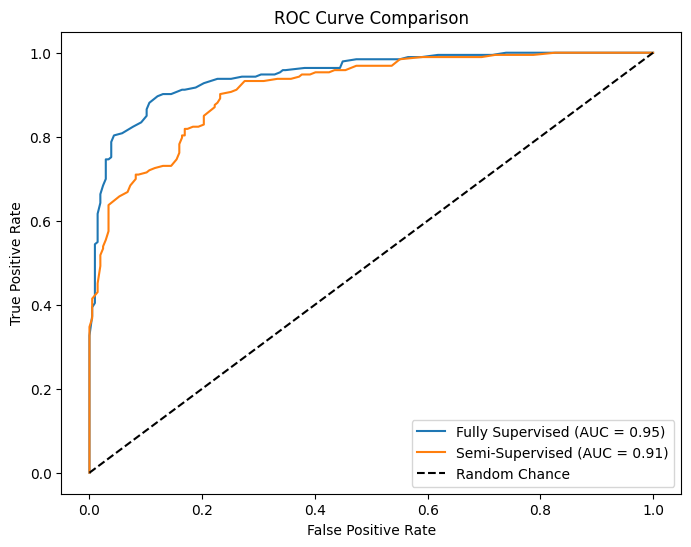

In [11]:
# 9. Plot ROC curves for both models
# Compute predicted probabilities for the positive class
y_proba_supervised = rf_supervised.predict_proba(X_test)[:, 1]
y_proba_semi = self_training_rf.predict_proba(X_test)[:, 1]

fpr_sup, tpr_sup, _ = roc_curve(y_test, y_proba_supervised)
roc_auc_sup = auc(fpr_sup, tpr_sup)

fpr_semi, tpr_semi, _ = roc_curve(y_test, y_proba_semi)
roc_auc_semi = auc(fpr_semi, tpr_semi)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sup, tpr_sup, label=f'Fully Supervised (AUC = {roc_auc_sup:.2f})')
plt.plot(fpr_semi, tpr_semi, label=f'Semi-Supervised (AUC = {roc_auc_semi:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

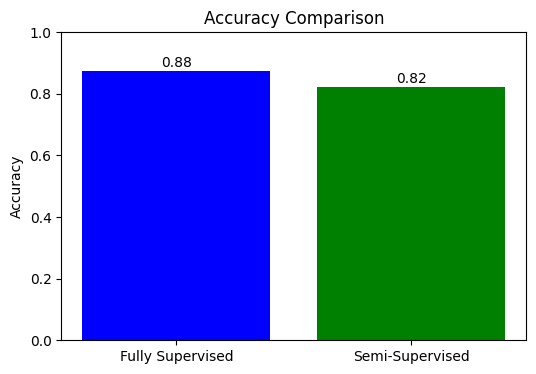

In [12]:

# 10. Compare accuracy scores with a bar plot
acc_supervised = accuracy_score(y_test, y_pred_supervised)
acc_semi = accuracy_score(y_test, y_pred_semi)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['Fully Supervised', 'Semi-Supervised'], [acc_supervised, acc_semi],
              color=['blue', 'green'])
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center')
plt.show()
